In [1]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem

In [2]:
def nesterov(x_0, grad, L, mu, K):
    x_cur = x_0
    y_cur = x_0
    x_list = [x_0]
    y_list = [x_0]
    for i in range(K):
        x_upd = y_cur - (1 / L) * (grad(y_cur, L))
        y_upd = x_upd + ((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))) * (x_upd - x_cur)

        x_list.append(x_upd)
        y_list.append(y_upd)

        x_cur = x_upd
        y_cur = y_upd

    return x_list, y_list

In [7]:
test_problem = TestProblem(gamma=100)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\iltya\AppData\Local\Temp/ipykernel_22496/657832001.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result, grad_x, grad_y = test_problem.calc(torch.tensor(x1_upd, requires_grad=True),
C:\Users\iltya\AppData\Local\Temp/ipykernel_22496/657832001.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x2_upd, requires_grad=True))
100%|██████████| 1000/1000 [00:03<00:00, 281.25it/s]


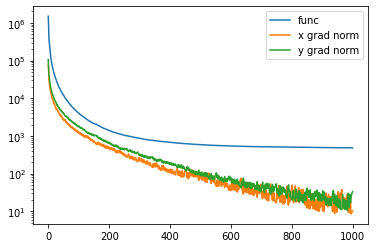

In [8]:
# ACRCD
history = []
grad_x_norms = []
grad_y_norms = []

# y (paper) = q(code_)

def ACRCD(x_0, y_0, K):
    x_list = [x_0]
    y_list = [y_0]

    z1_cur = x_0
    z2_cur = y_0

    q1_cur = x_0
    q2_cur = y_0

    L1 = L2 = 5000
    beta = 1 / 2

    n_ = L1 ** beta + L2 ** beta

    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1_upd = tau * z1_cur + (1 - tau) * q1_cur
        x2_upd = tau * z2_cur + (1 - tau) * q2_cur

        # test_problem.x = torch.tensor(x_upd, requires_grad=True)
        # test_problem.y = torch.tensor(y_upd, requires_grad=True)
        result, grad_x, grad_y = test_problem.calc(torch.tensor(x1_upd, requires_grad=True),
                                                   torch.tensor(x2_upd, requires_grad=True))
        history.append(result.item())
        grad_x_norms.append(torch.norm(grad_x).item())
        grad_y_norms.append(torch.norm(grad_y).item())
        #         print(result, torch.norm(grad_x), torch.norm(grad_y))

        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])

        if index_p == 0:
            q1_upd = x1_upd - (1 / L1) * grad_x
            q2_upd = q2_cur

            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur


        if index_p == 1:
            q1_upd = q1_cur
            q2_upd = x2_upd - (1 / L2) * grad_y

            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1_upd)
        y_list.append(x2_upd)

        z1_cur = z1_upd
        z2_cur = z2_upd

        q1_cur = q1_upd
        q2_cur = q2_upd

    return x_list, y_list


x_list_ACRCD, y_list_ACRCD = ACRCD(torch.rand(1000), torch.rand(2000, requires_grad=True), 1000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(history), label='func')
plt.plot(torch.tensor(grad_x_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:10<00:00, 97.28it/s]


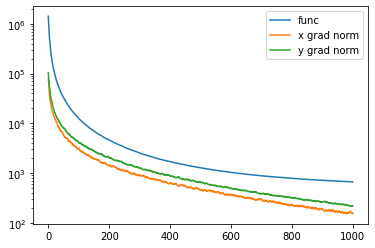

In [9]:

# ACRCD
history = []
grad_x_norms = []
grad_y_norms = []

# y (paper) = q(code_)

def ACRCD_star(x_0, y_0, K):
    ADAPRIVE_DELTA = 1

    x_list = [x_0]
    y_list = [y_0]

    z1_cur = x_0
    z2_cur = y_0

    q1_cur = x_0
    q2_cur = y_0

    L1 = L2 = 5000
    beta = 1 / 2


    # q_cur_block (code) = y (paper)
    # z_cur_block (code) = z (paper)
    for i in tqdm(range(K)):

        #####  redefine alpha, tau
        # n_ = L1 ** beta + L2 ** beta
        # alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)

        x1 = tau * z1_cur + (1 - tau) * q1_cur
        x2 = tau * z2_cur + (1 - tau) * q2_cur

        result, grad_x, grad_y = test_problem.calc(x1, x2)
        history.append(result.item())
        grad_x_norms.append(torch.norm(grad_x).item())
        grad_y_norms.append(torch.norm(grad_y).item())

        n_ = L1 ** beta + L2 ** beta
        index_p = np.random.choice([0, 1], p=[L1 ** beta / n_,
                                              L2 ** beta / n_])
        Ls = [L1, L2]
        Ls[index_p] /= 2

        # ADAPTIVE
        inequal_is_true = False
        while not inequal_is_true:
            xs = [x1, x2]

            res_x, *gradients_x = test_problem.calc(x1, x2)
            res_q, *gradients_q = test_problem.calc(q1_cur, q2_cur)
            sampled_gradient_x = gradients_x[index_p]

            inequal_is_true = 1 / (2 * Ls[index_p]) * torch.linalg.norm(sampled_gradient_x, dim=0, ord=2) ** 2 <= res_x - res_q + ADAPRIVE_DELTA

            if index_p == 0:
                q1_cur = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
            else:
                q2_cur = xs[index_p] - 1 / Ls[index_p] * sampled_gradient_x
            Ls[index_p] *= 2

            L1, L2 = Ls
            n_ = L1 ** beta + L2 ** beta
            alpha = (i + 2) / (2 * n_ ** 2)
        L1, L2 = Ls

        if index_p == 0:
            z1_upd = z1_cur - (1 / L1) * alpha * n_ * grad_x
            z2_upd = z2_cur

        if index_p == 1:
            z1_upd = z1_cur
            z2_upd = z2_cur - (1 / L2) * alpha * n_ * grad_y

        x_list.append(x1)
        y_list.append(x2)

        z1_cur = z1_upd
        z2_cur = z2_upd

    return x_list, y_list


x_list_ACRCD, y_list_ACRCD = ACRCD_star(torch.rand(1000), torch.rand(2000, requires_grad=True), 1000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(history), label='func')
plt.plot(torch.tensor(grad_x_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()